# Gross-Pitaevskii equation in one dimension
In this example we will use DFTK to solve
the Gross-Pitaevskii equation, and use this opportunity to explore a few internals.

## The model
The [Gross-Pitaevskii equation](https://en.wikipedia.org/wiki/Gross%E2%80%93Pitaevskii_equation) (GPE)
is a simple non-linear equation used to model bosonic systems
in a mean-field approach. Denoting by ``ψ`` the effective one-particle bosonic
wave function, the time-independent GPE reads in atomic units:
$$
    H ψ = \left(-\frac12 Δ + V + 2 C |ψ|^2\right) ψ = μ ψ \qquad \|ψ\|_{L^2} = 1
$$
where ``C`` provides the strength of the boson-boson coupling.
It's in particular a favorite model of applied mathematicians because it
has a structure simpler than but similar to that of DFT, and displays
interesting behavior (especially in higher dimensions with magnetic fields, see
Gross-Pitaevskii equation with magnetism).

We wish to model this equation in 1D using DFTK.
First we set up the lattice. For a 1D case we supply two zero lattice vectors,

In [1]:
a = 10
lattice = a .* [[1 0 0.]; [0 0 0]; [0 0 0]];

which is special cased in DFTK to support 1D models.

For the potential term `V` we just pick a harmonic
potential. The real-space grid is in ``[0,1)``
in fractional coordinates( see
Lattices and lattice vectors),
therefore:

In [2]:
pot(x) = (x - a/2)^2;

We setup each energy term in sequence: kinetic, potential and nonlinear term.
For the non-linearity we use the `PowerNonlinearity(C, α)` term of DFTK.
This object introduces an energy term ``C ∫ ρ(r)^α dr``
to the total energy functional, thus a potential term ``α C ρ^{α-1}``.
In our case we thus need the parameters

In [3]:
C = 1.0
α = 2;

... and with this build the model

In [4]:
using DFTK
using LinearAlgebra

n_electrons = 1  # Increase this for fun
terms = [Kinetic(),
         ExternalFromReal(r -> pot(r[1])),
         PowerNonlinearity(C, α),
]
model = Model(lattice; n_electrons=n_electrons, terms=terms,
              spin_polarization=:spinless);  # use "spinless electrons"

We discretize using a moderate Ecut (For 1D values up to `5000` are completely fine)
and run a direct minimization algorithm:

In [5]:
Ecut = 500
basis = PlaneWaveBasis(model, Ecut, kgrid=(1, 1, 1))
scfres = direct_minimization(basis, tol=1e-8) # This is a constrained preconditioned LBFGS
scfres.energies

Iter     Function value   Gradient norm 
     0     1.760969e+02     1.481442e+02
 * time: 0.0004668235778808594
     1     1.734060e+02     8.993708e+01
 * time: 0.001483917236328125
     2     1.694191e+02     1.022768e+02
 * time: 0.0029790401458740234
     3     1.175300e+02     9.287856e+01
 * time: 0.004745960235595703
     4     1.132156e+02     9.887434e+01
 * time: 0.006474971771240234
     5     5.146985e+01     7.100892e+01
 * time: 0.008218050003051758
     6     1.153423e+01     1.133877e+01
 * time: 0.009982824325561523
     7     7.526324e+00     1.919591e+01
 * time: 0.011174917221069336
     8     5.595417e+00     1.203083e+01
 * time: 0.012563943862915039
     9     4.542672e+00     1.089964e+01
 * time: 0.013692855834960938
    10     2.819445e+00     4.070079e+00
 * time: 0.014780044555664062
    11     1.744499e+00     1.829927e+00
 * time: 0.01582789421081543
    12     1.526890e+00     1.292165e+00
 * time: 0.01691603660583496
    13     1.312374e+00     1.047521

Energy breakdown:
    Kinetic             0.2682057 
    ExternalFromReal    0.4707475 
    PowerNonlinearity   0.4050836 

    total               1.144036852755 


## Internals
We use the opportunity to explore some of DFTK internals.

Extract the converged density and the obtained wave function:

In [6]:
ρ = real(scfres.ρ.real)[:, 1, 1]  # converged density
ψ_fourier = scfres.ψ[1][:, 1];    # first kpoint, all G components, first eigenvector

Transform the wave function to real space and fix the phase:

In [7]:
ψ = G_to_r(basis, basis.kpoints[1], ψ_fourier)[:, 1, 1]
ψ /= (ψ[div(end, 2)] / abs(ψ[div(end, 2)]));

Check whether ``ψ`` is normalised:

In [8]:
x = a * vec(first.(DFTK.r_vectors(basis)))
N = length(x)
dx = a / N  # real-space grid spacing
@assert sum(abs2.(ψ)) * dx ≈ 1.0

The density is simply built from ψ:

In [9]:
norm(scfres.ρ.real - abs2.(ψ))

1.034897658516556e-15

We summarize the ground state in a nice plot:

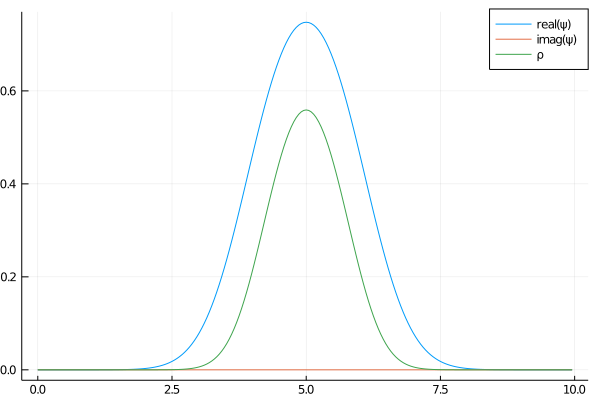

In [10]:
using Plots

p = plot(x, real.(ψ), label="real(ψ)")
plot!(p, x, imag.(ψ), label="imag(ψ)")
plot!(p, x, ρ, label="ρ")

The `energy_hamiltonian` function can be used to get the energy and
effective Hamiltonian (derivative of the energy with respect to the density matrix)
of a particular state (ψ, occupation).
The density ρ associated to this state is precomputed
and passed to the routine as an optimization.

In [11]:
E, ham = energy_hamiltonian(basis, scfres.ψ, scfres.occupation; ρ=scfres.ρ)
@assert E.total == scfres.energies.total

Now the Hamiltonian contains all the blocks corresponding to kpoints. Here, we just have one kpoint:

In [12]:
H = ham.blocks[1];

`H` can be used as a linear operator (efficiently using FFTs), or converted to a dense matrix:

In [13]:
ψ11 = scfres.ψ[1][:, 1] # first kpoint, first eigenvector
Hmat = Array(H) # This is now just a plain Julia matrix,
#                which we can compute and store in this simple 1D example
@assert norm(Hmat * ψ11 - H * ψ11) < 1e-10

Let's check that ψ11 is indeed an eigenstate:

In [14]:
norm(H * ψ11 - dot(ψ11, H * ψ11) * ψ11)

1.438755805213859e-7

Build a finite-differences version of the GPE operator ``H``, as a sanity check:

In [15]:
A = Array(Tridiagonal(-ones(N - 1), 2ones(N), -ones(N - 1)))
A[1, end] = A[end, 1] = -1
K = A / dx^2 / 2
V = Diagonal(pot.(x) + C .* α .* (ρ.^(α-1)))
H_findiff = K + V;
maximum(abs.(H_findiff*ψ - (dot(ψ, H_findiff*ψ) / dot(ψ, ψ)) * ψ))

0.00022343415757874406